In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.distributions import Normal, Independent, Categorical, MixtureSameFamily

In [15]:
np.random.seed(0)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

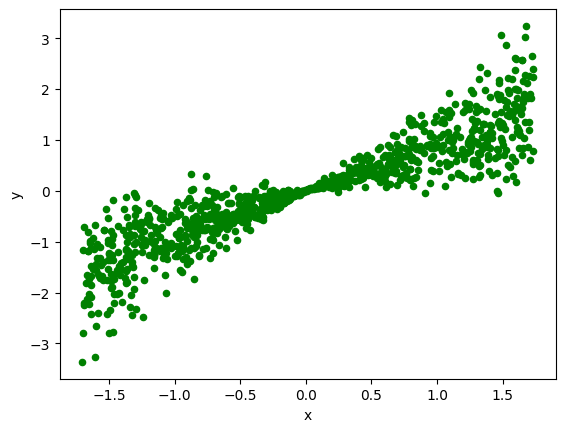

In [17]:
n = 1000
X = np.random.uniform(0, 10, size=(n, 1)).astype(np.float32)
y = (2 * X + 1 + np.random.normal(0, 1, size=(n, 1)) * (X - 5)).astype(
    np.float32
)  # Heteroscedasticity
#y = (2 * X + 1 + 3*np.random.normal(0, 1, size=(n, 1))).astype(
#    np.float32
#)  # Heteroscedasticity


X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

data = pd.DataFrame({"x": X.squeeze(), "y": y.squeeze()}).plot(
    kind="scatter", x="x", y="y", color="green"
);


In [18]:
def plot_credibility_interval(model, X, y, num_samples=50, fig=None, ax=None, y_min=-20, y_max=20):
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots()
    # Plot actual data
    X_np = X.detach().to(device="cpu").numpy()
    y_np = y.detach().to(device="cpu").numpy()
    scatter_actual = ax.scatter(X_np, y_np, color="green", label="Actual")

    sorting = X.detach().to(device="cpu").squeeze().sort()
    X_sorted = sorting.values.unsqueeze(1)

    predictions = []
    # Run multiple forward passes to get predictions for each input
    for _ in range(num_samples):
        y_hat_sample = model(X_sorted)[0]
        y_hat_np = y_hat_sample.to(device="cpu").detach().numpy().squeeze()
        predictions.append(y_hat_np)

    # Convert the predictions to a NumPy array for easier manipulation
    predictions = np.array(predictions)
    sample_mean = predictions.mean(axis=0)

    # Calculate mean and standard deviation across the samples
    y_hat_mean, y_hat_std = sample_mean[:, 0], sample_mean[:, 1]
    y_hat_std = np.log1p(np.exp(y_hat_std))

    # Calculate the 68.2% prediction interval (mean ± std)
    lower_bound = y_hat_mean - y_hat_std
    upper_bound = y_hat_mean + y_hat_std

    # Plot the prediction interval as a shaded region
    ax.fill_between(
        X_sorted.squeeze(-1),
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.6,
        label="68.2% Confidence Interval",
    )
    ax.plot(X_sorted.squeeze(-1), y_hat_mean, color="red")
    ax.set_ylim(y_min, y_max)
    return fig, ax


In [19]:
X_torch = torch.from_numpy(X).to(device=device)
y_torch = torch.from_numpy(y).squeeze().to(device=device)
print(X_torch.shape, y_torch.shape)

torch.Size([1000, 1]) torch.Size([1000])


In [20]:
class Layer(nn.Module):
    """
    A custom layer class for implementing a fully connected layer with
    Bayesian weights (reparameterized via `mu` and `rho`) and optional normalization.
    """

    def __init__(self, in_features, out_features, mu_mean=0, mu_std=1, rho_mean=-0.5, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = device
        self.dtype = dtype if dtype is not None else torch.float32
        self.bias = bias

        # Parameters for the Bayesian layer (weights)
        self.mu_w = nn.Parameter(
            torch.normal(mu_mean, mu_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        )
        self.rho_w = nn.Parameter(
            torch.normal(rho_mean, rho_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        )

        if self.bias:
            self.mu_b = nn.Parameter(
                torch.normal(mu_mean, mu_std, (out_features, 1), dtype=self.dtype, device=self.device)
            )
            self.rho_b = nn.Parameter(
                torch.normal(rho_mean, rho_std, (out_features, 1), dtype=self.dtype, device=self.device)
            )
        else:
            self.mu_b = None
            self.rho_b = None
        
    @property
    def mu(self):
        mu_tensor = self.flatten(self.mu_w, self.mu_b)
        return mu_tensor

    @property
    def rho(self):
        rho_tensor = self.flatten(self.rho_w, self.rho_b)
        return rho_tensor


    def num_params(self) -> int:
        # note number of network layer parameters is half this
        num = self.mu_w.numel() + self.rho_w.numel()
        if self.bias:
            num += self.mu_b.numel() + self.rho_b.numel()
        return int(num)

    def num_weights(self) -> int:
        return int(self.num_params()/2)

    def sample_weights(self):
        eps = torch.normal(
            0,
            1,
            self.mu_w.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_w))
        w = self.mu_w + sigma * eps
        return w

    def sample_bias(self):
        if not self.bias:
            return None
        eps = torch.normal(
            0,
            1,
            self.mu_b.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_b))
        b = self.mu_b + sigma * eps
        return b

    def sample(self):
        w = self.sample_weights()
        b = self.sample_bias()
        return w, b

    @staticmethod
    def flatten(weights, bias=None):
        if bias is not None:
            w = torch.cat([weights.flatten(), bias.flatten()])
        else:
            w = weights.flatten()
        return w
    
    def unflatten(self, weights: torch.Tensor):
        ws = self.mu_w.numel() # == self.mu_w.shape[0] * self.mu_w.shape[1]
        if self.bias:
            bs = self.mu_b.numel() # == self.mu_b.shape[0] * self.mu_b.shape[1]
            w, b = weights.split((ws, bs))
            w = w.reshape(self.mu_w.shape)
            b = b.reshape(self.mu_b.shape)
            return w, b

        else:
            w = weights.reshape(self.mu_w.shape)
            return w, None


    def forward(self, x):
        w, b = self.sample()
        y = x @ w.T
        if self.bias:
            y += b.T
        w = self.flatten(w, b)
        return y, w


class BayesNetwork(nn.Module):
    def __init__(self, num_input_features, num_output_features, mu_mean=0, mu_std=1, rho_mean=-1, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        hidden_dim = 8
        self.num_input_features = num_input_features
        self.num_output_features = num_output_features
        self.device = device
        self.dtype = dtype

        # Define the layers in the network
        self.layer1 = Layer(
            num_input_features,
            hidden_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer2 = Layer(
            hidden_dim,
            hidden_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer3 = Layer(
            hidden_dim,
            num_output_features,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )

    @property
    def mu(self):
        mu_tensor = torch.cat([self.layer1.mu, self.layer2.mu, self.layer3.mu])
        return mu_tensor

    @property
    def rho(self):
        rho_tensor = torch.cat([self.layer1.rho, self.layer2.rho, self.layer3.rho])
        return rho_tensor

    def forward(self, x):
        x = x.to(dtype=self.dtype, device=self.device)

        # Pass through the layers
        a1, w1 = self.layer1(x)
        z1 = F.tanh(a1)
        a2, w2 = self.layer2(z1)
        z2 = F.tanh(a2)
        x3, w3 = self.layer3(z2)

        params = [w1, w2, w3]
        w = torch.cat(params)

        return x3.squeeze(-1), w

    def num_weights(self):
        return self.layer1.num_weights() + self.layer2.num_weights() + self.layer3.num_weights()


# Example usage:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#num_input_features = 1 
#num_output_features = 1
#bias = True
#dtype = torch.float32
#
#
## Create the Bayesian network model
#model = BayesNetwork(num_input_features, num_output_features, device=device, bias=bias, dtype=dtype)
##model = Layer(1, 1, rho_std, device, bias, dtype)
#
## Forward pass
#_, _ = model(X_torch)

In [21]:
def train_with_lr_reducer(model, epochs=600, batch_size=1000, lr_start=1.0, is_linear=False):
    num_eps_samples = 50 # number of samples to average the loss over
    lr = lr_start
    optimizer = Adam(model.parameters(), lr=lr)
    lr_reducer = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    model.to(device=device)
    model.train()
    #fig, ax = plot_credibility_interval(model, X_torch, y_torch);


    dataset = TensorDataset(X_torch, y_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(epochs):
        kl_weight = get_kl_weight(epoch, epochs)
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            loss = torch.zeros((1,), device=device)
            for _ in range(num_eps_samples):
                y_hat, w = model(batch_X)
                loss += loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight)
            loss /= num_eps_samples
            loss.backward()
            optimizer.step()
        lr_reducer.step(loss)
        if is_linear:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr_reducer.get_last_lr()[0]:.2f} | loss={loss.item():.2f} | y_p = {model.mu_w.item():.4f} (+- {torch.log1p(torch.exp(model.rho_w)).item():.4f})x + {model.mu_b.item():.4f} (+- {torch.log1p(torch.exp(model.rho_b)).item():.4f})"
            )
        else:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr} | loss={loss.item()} | ||mu|| = {torch.linalg.vector_norm(model.mu).item():.2f} | ||rho|| = {torch.linalg.vector_norm(model.rho).item():.2f}"
            )
        if (epoch+1) % 20 == 0:
            fig, ax = plot_credibility_interval(model, X_torch, y_torch);
            loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight, verbose=True)
            print()
        plt.show()

    fig, ax = plot_credibility_interval(model, X_torch, y_torch);

In [22]:
def create_gmm(num_params, sigmas, weights, device=device):
    """
    Creates a Gaussian Mixture Model (GMM) of multivariate normal of size num_params with mean 0 and standard deviations provided by sigmas.

    Args:
        num_params (int): The number of parameters.
        sigmas (list of float): Standard deviations for the Gaussian components.
        weights (list of float): Mixture weights for each component, should sum to 1.

    Returns:
        MixtureSameFamily: A Gaussian Mixture Model distribution with multivariate normal components.
        sum(i=1...len(sigmas)) weight[i] * N(0, sigma[i])

    Example:
        >>> w = torch.cat([param.flatten() for param in model.parameters()])
        >>> p_w = create_gmm(w.shape[0], (1.0, 0.1), (0.75, 0.25))
        >>> p_w.log_prob(w)
        tensor(1402409.1250, grad_fn=<LogsumexpBackward0>)
    """

    num_mixtures = len(sigmas)
    means = torch.zeros(
        (num_mixtures, num_params), device=device
    )  # Shape: (num_mixtures, num_params)

    # Create diagonal standard deviations for each component based on sigmas
    stds = torch.stack(
        [torch.ones(num_params, device=device) * sigma for sigma in sigmas],
    )  # Shape: (num_mixtures, num_params)

    # Use Normal + Independence instead of MultivariateNormal to prevent too many non-sparse covariance matrices
    normal_dists = Normal(means, stds)  # Shape: (num_mixtures, num_params)

    # Treat columns as different independent events to collapse across columns (1)
    independent_dists = Independent(
        normal_dists, 1
    ) # (num_mixtures,)

    # Define the categorical distribution over components with specified weights
    cat = Categorical(torch.tensor(weights, device=device))

    # Create the Gaussian Mixture Model
    gmm = MixtureSameFamily(cat, independent_dists)

    return gmm


In [23]:

def get_variational_pdf(mu, rho):
    # Compute sigma as before
    sigma = torch.log1p(torch.exp(rho))

    # Define independent Normal distributions for each num_paramsension
    q_theta = D.Independent(D.Normal(mu, sigma), 1)

    return q_theta


def loss_fn(y_hat, y, w, mu, rho, kl_weight=1.0, verbose=False):
    y_hat_mu = y_hat[:, 0]
    y_hat_sigma = y_hat[:, 1]
    y_hat_sigma = torch.log1p(torch.exp(y_hat_sigma))
    normal_dists = Normal(y_hat_mu, y_hat_sigma)

    likelihood = Independent(
        normal_dists, 1
    )

    q_theta = get_variational_pdf(mu, rho)
    p_w = create_gmm(len(w), (0.75, 0.1), (0.25, 0.75))

    q_theta_loss = q_theta.log_prob(w)
    p_w_neg_loss = p_w.log_prob(w)
    kl_loss = (q_theta_loss - p_w_neg_loss)
    log_likelihood = likelihood.log_prob(y)
    nll_loss = -log_likelihood
    loss = (nll_loss + kl_weight * kl_loss)
    if verbose:
        print(
            f"Loss: {loss.detach().to(device='cpu').item()}| nll: {nll_loss.detach().to(device='cpu').item()}| kl: {kl_loss.detach().to(device='cpu').item()} (weight: {kl_weight:.2f}) = {q_theta_loss.detach().to(device='cpu').item()} (variational) - {p_w_neg_loss.detach().to(device='cpu').item()} (prior)"
        )
    return loss


def get_kl_weight(epoch, epochs):
    # exponential growth
    # This grows more slowly at the start and levels off near 1 as epoch approaches epochs.
    kl_weight = 1 - np.exp(-epoch / (epochs * 0.1))
    return kl_weight

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_input_features = 1
num_output_features = 2
bias = True
dtype = torch.float32

mu_mean, mu_std = (0, 1.0)
rho_mean, rho_std = (-1, 0.1)

# Create the Bayesian network model
model = BayesNetwork(
    num_input_features, num_output_features, mu_mean=mu_mean, mu_std=mu_std, rho_mean=rho_mean, rho_std=rho_std, device=device, bias=bias, dtype=dtype
)


# Forward pass
_, _ = model(X_torch)


# prior

# p_w = create_gmm(model.num_weights(), (1, 0.1), (0.25, 0.75))

epoch=1/200 | lr=1 | loss=22618.8046875 | ||mu|| = 13.94 | ||rho|| = 15.20
epoch=2/200 | lr=1 | loss=64385.328125 | ||mu|| = 17.34 | ||rho|| = 19.94
epoch=3/200 | lr=1 | loss=3063.88916015625 | ||mu|| = 21.20 | ||rho|| = 24.56
epoch=4/200 | lr=1 | loss=5590.3037109375 | ||mu|| = 24.81 | ||rho|| = 28.56
epoch=5/200 | lr=1 | loss=3566.9638671875 | ||mu|| = 28.04 | ||rho|| = 32.08
epoch=6/200 | lr=1 | loss=3785.037109375 | ||mu|| = 30.91 | ||rho|| = 35.18
epoch=7/200 | lr=1 | loss=4069.9677734375 | ||mu|| = 33.44 | ||rho|| = 37.91
epoch=8/200 | lr=1 | loss=4165.89990234375 | ||mu|| = 35.71 | ||rho|| = 40.29
epoch=9/200 | lr=1 | loss=4261.548828125 | ||mu|| = 37.75 | ||rho|| = 42.41
epoch=10/200 | lr=1 | loss=4422.47802734375 | ||mu|| = 39.57 | ||rho|| = 44.31
epoch=11/200 | lr=1 | loss=4599.7138671875 | ||mu|| = 41.22 | ||rho|| = 46.01
epoch=12/200 | lr=1 | loss=4742.60791015625 | ||mu|| = 42.70 | ||rho|| = 47.54
epoch=13/200 | lr=1 | loss=4954.8408203125 | ||mu|| = 44.04 | ||rho|| = 48.9

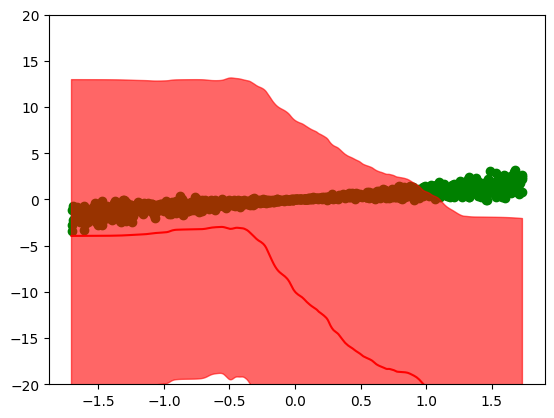

epoch=21/200 | lr=1 | loss=5814.2158203125 | ||mu|| = 48.15 | ||rho|| = 52.80
epoch=22/200 | lr=1 | loss=5914.087890625 | ||mu|| = 48.43 | ||rho|| = 53.04
epoch=23/200 | lr=1 | loss=5974.31982421875 | ||mu|| = 48.68 | ||rho|| = 53.25
epoch=24/200 | lr=1 | loss=6080.69677734375 | ||mu|| = 48.91 | ||rho|| = 53.45
epoch=25/200 | lr=1 | loss=6111.91748046875 | ||mu|| = 49.11 | ||rho|| = 53.62
epoch=26/200 | lr=1 | loss=6196.056640625 | ||mu|| = 49.20 | ||rho|| = 53.70
epoch=27/200 | lr=1 | loss=6247.16064453125 | ||mu|| = 49.28 | ||rho|| = 53.77
epoch=28/200 | lr=1 | loss=6229.6611328125 | ||mu|| = 49.36 | ||rho|| = 53.83
epoch=29/200 | lr=1 | loss=6264.3369140625 | ||mu|| = 49.42 | ||rho|| = 53.88
epoch=30/200 | lr=1 | loss=6376.7080078125 | ||mu|| = 49.48 | ||rho|| = 53.92
epoch=31/200 | lr=1 | loss=6375.28759765625 | ||mu|| = 49.54 | ||rho|| = 53.96
epoch=32/200 | lr=1 | loss=6468.72021484375 | ||mu|| = 49.58 | ||rho|| = 53.99
epoch=33/200 | lr=1 | loss=6483.4755859375 | ||mu|| = 49.62 

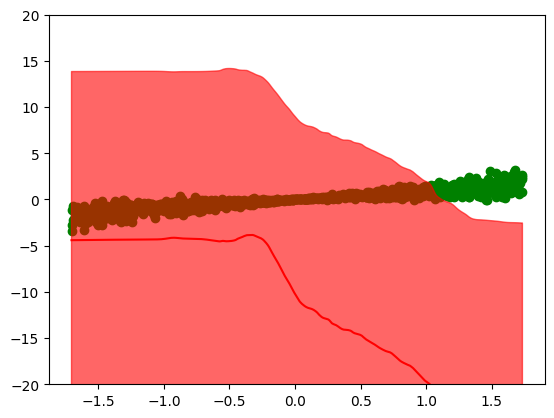

epoch=41/200 | lr=1 | loss=6974.03564453125 | ||mu|| = 49.78 | ||rho|| = 54.06
epoch=42/200 | lr=1 | loss=6756.6298828125 | ||mu|| = 49.80 | ||rho|| = 54.05
epoch=43/200 | lr=1 | loss=6722.1337890625 | ||mu|| = 49.82 | ||rho|| = 54.04
epoch=44/200 | lr=1 | loss=6727.552734375 | ||mu|| = 49.84 | ||rho|| = 54.03
epoch=45/200 | lr=1 | loss=6759.11669921875 | ||mu|| = 49.85 | ||rho|| = 54.02
epoch=46/200 | lr=1 | loss=6795.7294921875 | ||mu|| = 49.86 | ||rho|| = 54.01
epoch=47/200 | lr=1 | loss=6830.28125 | ||mu|| = 49.87 | ||rho|| = 54.00
epoch=48/200 | lr=1 | loss=6831.6162109375 | ||mu|| = 49.88 | ||rho|| = 54.00
epoch=49/200 | lr=1 | loss=6833.6337890625 | ||mu|| = 49.88 | ||rho|| = 53.99
epoch=50/200 | lr=1 | loss=6872.98291015625 | ||mu|| = 49.88 | ||rho|| = 53.99
epoch=51/200 | lr=1 | loss=6843.380859375 | ||mu|| = 49.89 | ||rho|| = 53.98
epoch=52/200 | lr=1 | loss=6945.73681640625 | ||mu|| = 49.89 | ||rho|| = 53.97
epoch=53/200 | lr=1 | loss=6932.763671875 | ||mu|| = 49.89 | ||rho|

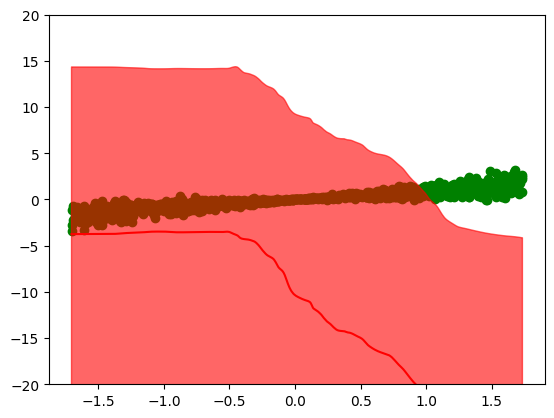

epoch=61/200 | lr=1 | loss=6904.568359375 | ||mu|| = 49.88 | ||rho|| = 53.92
epoch=62/200 | lr=1 | loss=6939.015625 | ||mu|| = 49.88 | ||rho|| = 53.91
epoch=63/200 | lr=1 | loss=6894.8720703125 | ||mu|| = 49.88 | ||rho|| = 53.91
epoch=64/200 | lr=1 | loss=6970.6279296875 | ||mu|| = 49.88 | ||rho|| = 53.91
epoch=65/200 | lr=1 | loss=6969.42431640625 | ||mu|| = 49.88 | ||rho|| = 53.90
epoch=66/200 | lr=1 | loss=7058.822265625 | ||mu|| = 49.88 | ||rho|| = 53.90
epoch=67/200 | lr=1 | loss=6968.947265625 | ||mu|| = 49.87 | ||rho|| = 53.89
epoch=68/200 | lr=1 | loss=7012.271484375 | ||mu|| = 49.87 | ||rho|| = 53.88
epoch=69/200 | lr=1 | loss=6972.05810546875 | ||mu|| = 49.87 | ||rho|| = 53.88
epoch=70/200 | lr=1 | loss=6983.1318359375 | ||mu|| = 49.87 | ||rho|| = 53.87
epoch=71/200 | lr=1 | loss=6948.56689453125 | ||mu|| = 49.87 | ||rho|| = 53.87
epoch=72/200 | lr=1 | loss=6975.939453125 | ||mu|| = 49.87 | ||rho|| = 53.87
epoch=73/200 | lr=1 | loss=6965.4482421875 | ||mu|| = 49.87 | ||rho|| 

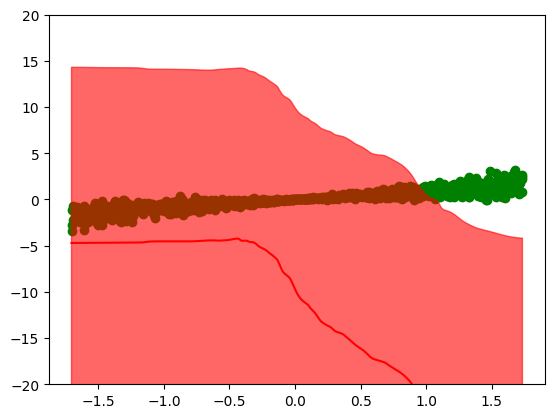

epoch=81/200 | lr=1 | loss=7099.84814453125 | ||mu|| = 49.86 | ||rho|| = 53.84
epoch=82/200 | lr=1 | loss=6993.0908203125 | ||mu|| = 49.86 | ||rho|| = 53.84
epoch=83/200 | lr=1 | loss=7027.12255859375 | ||mu|| = 49.85 | ||rho|| = 53.84
epoch=84/200 | lr=1 | loss=6953.626953125 | ||mu|| = 49.85 | ||rho|| = 53.84
epoch=85/200 | lr=1 | loss=7039.25146484375 | ||mu|| = 49.85 | ||rho|| = 53.84
epoch=86/200 | lr=1 | loss=7049.841796875 | ||mu|| = 49.85 | ||rho|| = 53.84
epoch=87/200 | lr=1 | loss=7020.076171875 | ||mu|| = 49.85 | ||rho|| = 53.84
epoch=88/200 | lr=1 | loss=7040.9326171875 | ||mu|| = 49.85 | ||rho|| = 53.84
epoch=89/200 | lr=1 | loss=7038.1220703125 | ||mu|| = 49.85 | ||rho|| = 53.83
epoch=90/200 | lr=1 | loss=7019.80810546875 | ||mu|| = 49.85 | ||rho|| = 53.83
epoch=91/200 | lr=1 | loss=7068.255859375 | ||mu|| = 49.85 | ||rho|| = 53.83
epoch=92/200 | lr=1 | loss=7068.666015625 | ||mu|| = 49.85 | ||rho|| = 53.83
epoch=93/200 | lr=1 | loss=7025.2939453125 | ||mu|| = 49.85 | ||r

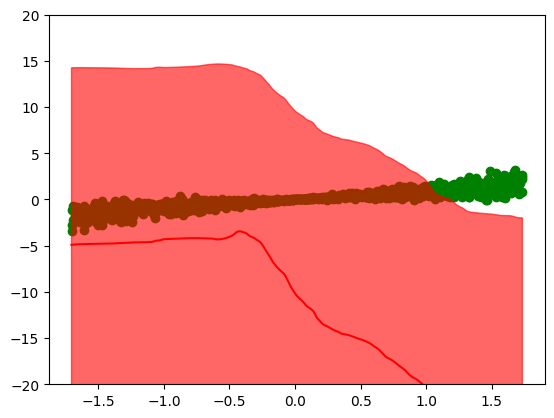

epoch=101/200 | lr=1 | loss=7109.884765625 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=102/200 | lr=1 | loss=6973.431640625 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=103/200 | lr=1 | loss=7039.4814453125 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=104/200 | lr=1 | loss=7071.43310546875 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=105/200 | lr=1 | loss=7086.21875 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=106/200 | lr=1 | loss=7054.1220703125 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=107/200 | lr=1 | loss=7038.8505859375 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=108/200 | lr=1 | loss=7050.24609375 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=109/200 | lr=1 | loss=7028.34130859375 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=110/200 | lr=1 | loss=7036.115234375 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=111/200 | lr=1 | loss=7071.2001953125 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=112/200 | lr=1 | loss=7075.90625 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=113/200 | lr=1 | loss=7118.73193359375 | ||mu|| = 49.84 | |

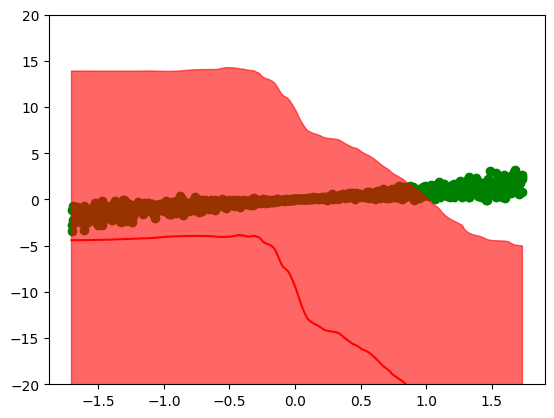

epoch=121/200 | lr=1 | loss=7074.26708984375 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=122/200 | lr=1 | loss=7196.02294921875 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=123/200 | lr=1 | loss=7070.51513671875 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=124/200 | lr=1 | loss=7055.6025390625 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=125/200 | lr=1 | loss=7018.01513671875 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=126/200 | lr=1 | loss=7459.2470703125 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=127/200 | lr=1 | loss=7103.2236328125 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=128/200 | lr=1 | loss=7087.09521484375 | ||mu|| = 49.84 | ||rho|| = 53.82
epoch=129/200 | lr=1 | loss=7101.90478515625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=130/200 | lr=1 | loss=7076.14013671875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=131/200 | lr=1 | loss=6991.71044921875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=132/200 | lr=1 | loss=7117.23681640625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=133/200 | lr=1 | loss=7067.84765625 |

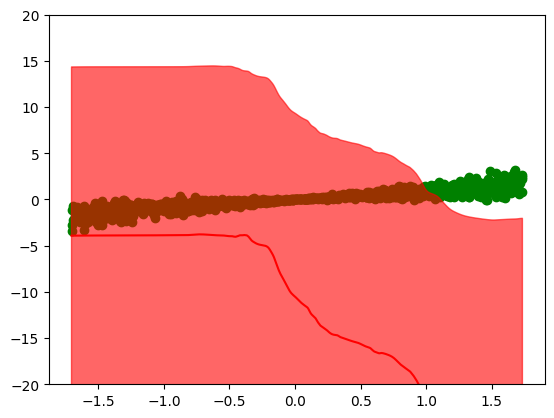

epoch=141/200 | lr=1 | loss=7015.568359375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=142/200 | lr=1 | loss=7100.69677734375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=143/200 | lr=1 | loss=7072.44921875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=144/200 | lr=1 | loss=7478.244140625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=145/200 | lr=1 | loss=7140.45703125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=146/200 | lr=1 | loss=7113.169921875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=147/200 | lr=1 | loss=7082.091796875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=148/200 | lr=1 | loss=7144.51318359375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=149/200 | lr=1 | loss=7047.82763671875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=150/200 | lr=1 | loss=7141.900390625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=151/200 | lr=1 | loss=7048.25439453125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=152/200 | lr=1 | loss=7164.56640625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=153/200 | lr=1 | loss=7112.599609375 | ||mu|| = 49.84

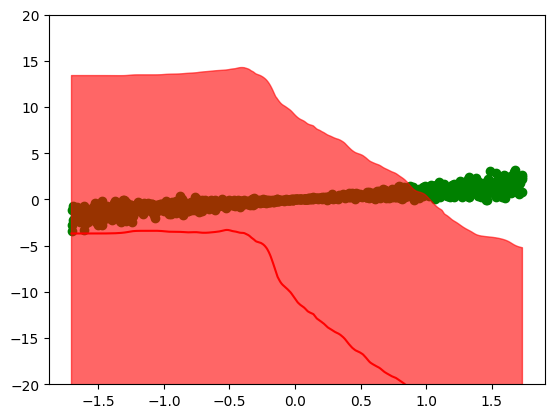

epoch=161/200 | lr=1 | loss=9671.7177734375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=162/200 | lr=1 | loss=7075.20703125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=163/200 | lr=1 | loss=7088.55517578125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=164/200 | lr=1 | loss=7047.53125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=165/200 | lr=1 | loss=7103.05810546875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=166/200 | lr=1 | loss=7083.14453125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=167/200 | lr=1 | loss=7088.80810546875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=168/200 | lr=1 | loss=7073.96826171875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=169/200 | lr=1 | loss=7057.7138671875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=170/200 | lr=1 | loss=7093.35888671875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=171/200 | lr=1 | loss=7038.5517578125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=172/200 | lr=1 | loss=7051.3857421875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=173/200 | lr=1 | loss=7047.60205078125 | ||mu|| = 

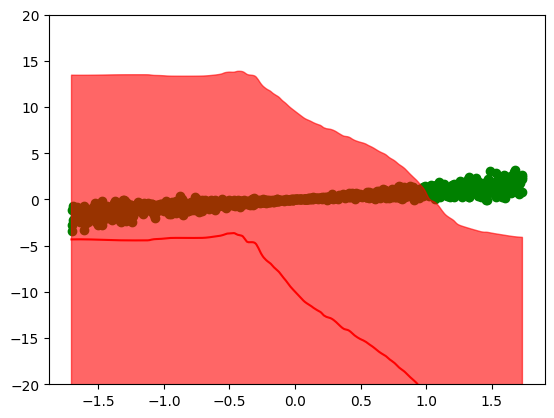

epoch=181/200 | lr=1 | loss=7136.083984375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=182/200 | lr=1 | loss=7042.84375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=183/200 | lr=1 | loss=7056.451171875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=184/200 | lr=1 | loss=7060.849609375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=185/200 | lr=1 | loss=7098.248046875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=186/200 | lr=1 | loss=7054.95703125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=187/200 | lr=1 | loss=7077.8017578125 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=188/200 | lr=1 | loss=7034.85791015625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=189/200 | lr=1 | loss=7136.671875 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=190/200 | lr=1 | loss=7106.95556640625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=191/200 | lr=1 | loss=7037.525390625 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=192/200 | lr=1 | loss=7011.068359375 | ||mu|| = 49.84 | ||rho|| = 53.81
epoch=193/200 | lr=1 | loss=7045.40576171875 | ||mu|| = 49.84 | ||r

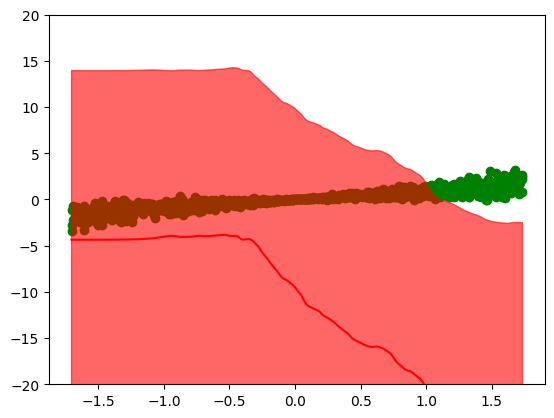

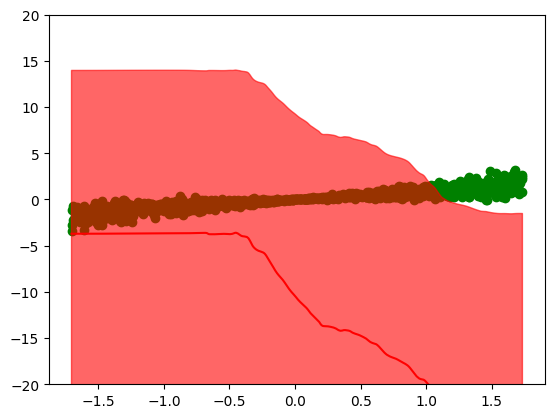

In [25]:
train_with_lr_reducer(model, batch_size=1000, lr_start=1, epochs=200)

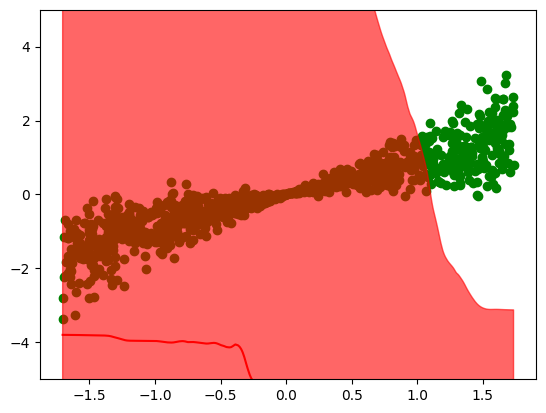

In [26]:
plot_credibility_interval(model, X_torch, y_torch, y_min=-5, y_max=5, num_samples=100);